In [183]:
# Check if the python notebook is working
print("Im Working!")

Im Working!


In [184]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm
import seaborn as sns

In [185]:
# Read the dataset
df = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
Sex,,,,,,,
female,259,259,259,259,259,259,259
male,453,453,453,453,453,453,453


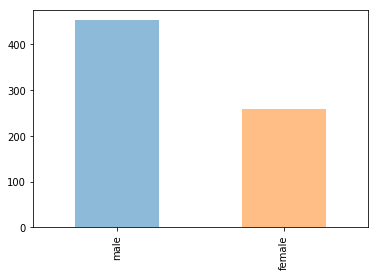

In [186]:
# Since there are a lot of missing values in ticket and cabin we will drop them
# Additionally features like Name and PassengerId carry no apparent importance as features, so they will also be removed, 
# before applying encoding on our categorical values 
df = df.drop(['Name', 'PassengerId', 'Ticket','Cabin'], axis=1) 
df = df.dropna()

df.Sex.value_counts().plot(kind='bar', alpha = 0.5)
df.groupby('Sex').count()

## Wrapper Methods

We will use the random forest algorithm. This method is part of the scikit package and requires all features to be continueous values. Thus pre-processing of the data is imperative. All categorical features will be encoded into one-hot arrays. It is known that such an approach can hurt performance. 

In [187]:
# Split our training data for training + validation
from sklearn.model_selection import train_test_split

# Which columns to grab from the dataset
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# Grab the columns for the transformation
all_X = df[columns]
all_y = df['Survived']

# Define our train and test sets
train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)
print('Training dataset shape:', train_X.shape, train_y.shape)
print('Testing dataset shape:', test_X.shape, test_y.shape)

('Training dataset shape:', (569, 8), (569L,))
('Testing dataset shape:', (143, 8), (143L,))


In [188]:
# Encoding our categorical data into one-hot arrays

# Encode Pclass, Sex and Embarked features
sex_enc = pd.get_dummies(train_X['Sex'])
embarked_enc = pd.get_dummies(train_X['Embarked'])
pclass_enc =  pd.get_dummies(train_X['Pclass'])

# Remove existing columns 
# Survived feature removed so as not to correlate 100% with only one feature during feature subset selection
train_X = train_X.drop(['Survived', 'Sex', 'Embarked', 'Pclass'], axis=1)

# Replace them with encoded ones
train_X = train_X.join(sex_enc)
train_X = train_X.join(embarked_enc)
train_X = train_X.join(pclass_enc)
train_X.columns = ['Age', 'SibSp', 'Parch', 'Fare', 
              'female', 'male', 
              'Embarked_C', 'Embarked_Q', 'Embarked_S', 
              'Pclass_1', 'Pclass_2', 'Pclass_3']
print(train_X)

      Age  SibSp  Parch      Fare  female  male  Embarked_C  Embarked_Q  \
867  31.0      0      0   50.4958       0     1           0           0   
332  38.0      0      1  153.4625       0     1           0           0   
20   35.0      0      0   26.0000       0     1           0           0   
606  30.0      0      0    7.8958       0     1           0           0   
379  19.0      0      0    7.7750       0     1           0           0   
314  43.0      1      1   26.2500       0     1           0           0   
395  22.0      0      0    7.7958       0     1           0           0   
590  35.0      0      0    7.1250       0     1           0           0   
821  27.0      0      0    8.6625       0     1           0           0   
293  24.0      0      0    8.8500       1     0           0           0   
299  50.0      0      1  247.5208       1     0           1           0   
205   2.0      0      1   10.4625       1     0           0           0   
60   22.0      0      0  

In [189]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=6,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   10.1s finished

[2018-09-27 17:17:17] Features: 1/6 -- score: 0.776821854559446[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   10.0s finished

[2018-09-27 17:17:27] Features: 2/6 -- score: 0.7978761061946903[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.6s finished

[2018-09-27 17:17:36] Features: 3/6 -- score: 0.808341669873028[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 ou

In [190]:
print(list(sfs1.k_feature_idx_))
(sfs1.subsets_)

[4, 5, 6, 7, 8, 11]


{1: {'avg_score': 0.776821854559446,
  'cv_scores': array([0.74782609, 0.8       , 0.75221239, 0.78761062, 0.79646018]),
  'feature_idx': (4,),
  'feature_names': ('female',)},
 2: {'avg_score': 0.7978761061946903,
  'cv_scores': array([0.8       , 0.8       , 0.7699115 , 0.79646018, 0.82300885]),
  'feature_idx': (4, 11),
  'feature_names': ('female', 'Pclass_3')},
 3: {'avg_score': 0.808341669873028,
  'cv_scores': array([0.82608696, 0.8173913 , 0.77876106, 0.79646018, 0.82300885]),
  'feature_idx': (4, 8, 11),
  'feature_names': ('female', 'Embarked_S', 'Pclass_3')},
 4: {'avg_score': 0.808341669873028,
  'cv_scores': array([0.82608696, 0.8173913 , 0.77876106, 0.79646018, 0.82300885]),
  'feature_idx': (4, 5, 8, 11),
  'feature_names': ('female', 'male', 'Embarked_S', 'Pclass_3')},
 5: {'avg_score': 0.803093497499038,
  'cv_scores': array([0.80869565, 0.8173913 , 0.77876106, 0.78761062, 0.82300885]),
  'feature_idx': (4, 5, 6, 8, 11),
  'feature_names': ('female', 'male', 'Embarked_

Becomes apparent that the best feature set is consists of 3 features; namely: female, Pclass_3 and Embarked_S